In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from sklearn.metrics._classification import log_loss

Import Datasets & Merging 

In [104]:
train_var = pd.read_csv("./training_variants")
train_var.head(5)
train_var.nunique()

ID           3321
Gene          264
Variation    2996
Class           9
dtype: int64

In [91]:
train_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [92]:
train_text = pd.read_csv("./training_text", sep='\|\|', names=['ID', 'Text'], skiprows=1, 
                         encoding='utf-8')
train_text.head()
#train_text.info()

/var/folders/tm/dj0qxgcn4j75czpgvwyxxztc0000gn/T/ipykernel_197/66049121.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_text = pd.read_csv("./training_text", sep='\|\|', names=['ID', 'Text'], skiprows=1,


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [93]:
test_var = pd.read_csv("./test_variants")
test_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5668 non-null   int64 
 1   Gene       5668 non-null   object
 2   Variation  5668 non-null   object
dtypes: int64(1), object(2)
memory usage: 133.0+ KB


In [94]:
test_text = pd.read_csv("./test_text", sep='\|\|', names=['ID', 'Text'], skiprows=1, 
                         encoding='utf-8')

/var/folders/tm/dj0qxgcn4j75czpgvwyxxztc0000gn/T/ipykernel_197/2475086242.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_text = pd.read_csv("./test_text", sep='\|\|', names=['ID', 'Text'], skiprows=1,


In [81]:
# nltk.download()
# nltk.download('stopwords')
#stopwords = nltk.corpus.stopwords.words('english')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Error loading stopwords: <urlopen error EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1002)>


False

In [74]:
# stopwords = set(stopwords.words('english'))

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/lilisen/nltk_data'
    - '/Users/lilisen/anaconda3/nltk_data'
    - '/Users/lilisen/anaconda3/share/nltk_data'
    - '/Users/lilisen/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [87]:
# 处理text数据
# def clean_text(text):
#     if type(text) is str:
#         text = re.sub('[^a-zA-Z0-9\n]', '', text)
#         text = text.lower()
#     return text

# train_text['Text'] = train_text['Text'].apply(clean_text)

In [95]:
data = train_var.merge(train_text, on='ID', how='left')
#data.info()
data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [96]:
data.loc[data['Text'].isnull(), 'Text'] = data['Gene'] + ' ' + data['Variation']

Split data into train, validation, test

In [97]:
y_true = data['Class'].values
train_val_x, X_test, train_val_y, y_test = train_test_split(data, y_true, stratify=y_true, 
                                                            test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(train_val_x, train_val_y, stratify=train_val_y, 
                                                  test_size=0.2)

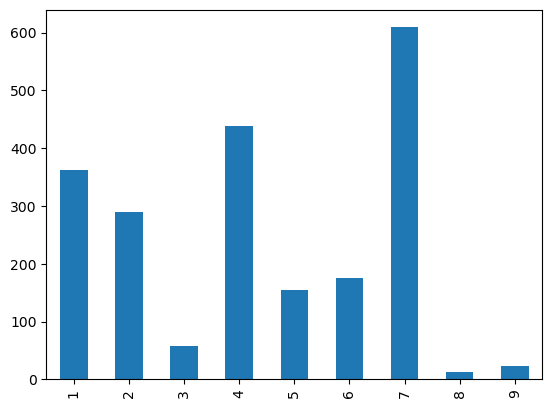

In [98]:
# train data distribution
train_dist = X_train['Class'].value_counts().sort_index()
train_dist.plot(kind='bar')
plt.show()

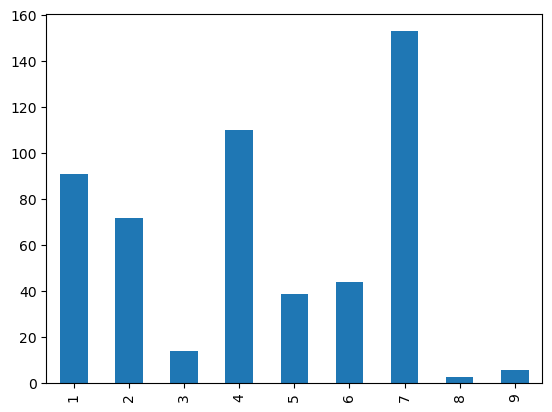

In [99]:
# val data distribution
val_dist = X_val['Class'].value_counts().sort_index()
val_dist.plot(kind='bar')
plt.show()

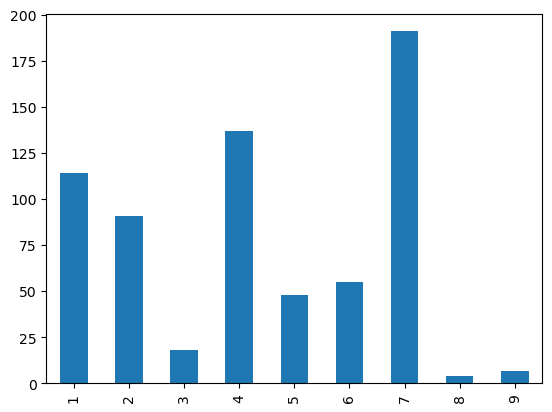

In [100]:
# test data distribution
test_dist = X_test['Class'].value_counts().sort_index()
test_dist.plot(kind='bar')
plt.show()

In [101]:
# 处理Gene 
# one-hot encoding
gene_cv = CountVectorizer()
train_gene_onehot = gene_cv.fit_transform(X_train['Gene'])
val_gene_onehot = gene_cv.transform(X_val['Gene'])
test_gene_onehot = gene_cv.transform(X_test['Gene'])

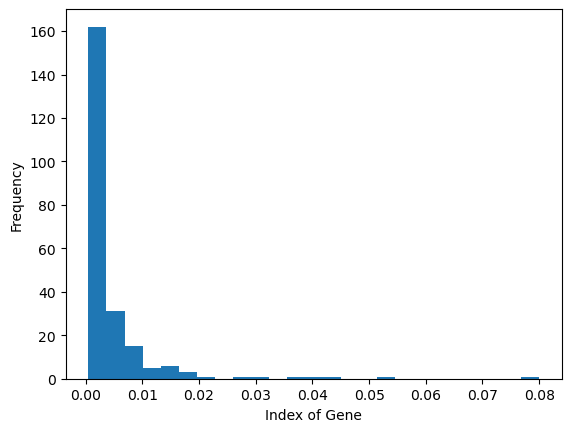

In [102]:
# Gene distribution
total = sum(X_train['Gene'].value_counts().values)
h = X_train['Gene'].value_counts().values / total
plt.hist(h, bins=25)
plt.xlabel('Index of Gene')
plt.ylabel('Frequency')
plt.show()

In [103]:
# 处理Variation
# one-hot encoding
var_cv = CountVectorizer()
train_var_onehot = var_cv.fit_transform(X_train['Variation'])
val_var_onehot = var_cv.transform(X_val['Variation'])
test_var_onehot = var_cv.transform(X_test['Variation'])

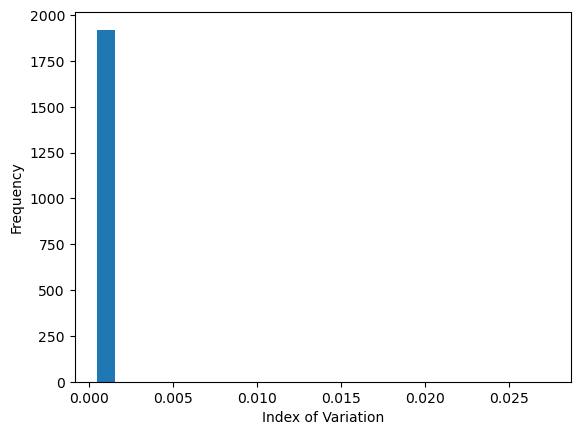

In [106]:
# Variation distribution
total1 = sum(X_train['Variation'].value_counts().values)
h1 = X_train['Variation'].value_counts().values / total1
plt.hist(h1, bins=25)
plt.xlabel('Index of Variation')
plt.ylabel('Frequency')
plt.show()


In [107]:
# 处理Text
text_cv = CountVectorizer(stop_words='english', min_df=3)
train_text_onehot = text_cv.fit_transform(X_train['Text'])
val_text_onehot = text_cv.transform(X_val['Text'])
test_text_onehot = text_cv.transform(X_test['Text'])

train_text_onehot = normalize(train_text_onehot, axis = 0)
val_text_onehot = normalize(val_text_onehot, axis = 0)
test_text_onehot = normalize(test_text_onehot, axis = 0)

In [60]:
# 合并one hot encoding features
train_onehot = hstack((hstack((train_gene_onehot, train_var_onehot)), train_text_onehot)).tocsr()
val_onehot = hstack((hstack((val_gene_onehot, val_var_onehot)), val_text_onehot)).tocsr()
test_onehot = hstack((hstack((test_gene_onehot, test_var_onehot)), test_text_onehot)).tocsr()

Building Models
1. KNN
2. Random Forest

In [142]:
# KNN
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
loss_list = []

for i in alpha:
    clf = KNeighborsClassifier(n_neighbors=i)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(train_onehot, y_train)
    y_pred = sig_clf.predict_proba(val_onehot)
    loss = log_loss(y_val, y_pred)
    loss_list.append(loss)
    print(loss)


1.8346576445506344
1.8339268934204505
1.8297584242383667
1.8319966133084626
1.8337972714293085
1.8353478140757726
1.8348498933261204
1.8338427462031914


In [146]:
best_alpha = alpha[np.argmin(loss_list)]
clf = KNeighborsClassifier(n_neighbors = best_alpha)
knn = CalibratedClassifierCV(clf)
knn.fit(train_onehot, y_train)

y_pred1 = knn.predict_proba(train_onehot)
print('For values of best alpha:', best_alpha, "The train log loss is:", log_loss(y_train, y_pred1))

y_pred2 = knn.predict_proba(val_onehot)
print('For values of best alpha:', best_alpha, "The val log loss is:", log_loss(y_val, y_pred2))

y_pred = knn.predict_proba(test_onehot)
print('For values of best alpha:', best_alpha, "The test log loss is:", log_loss(y_test, y_pred))

For values of best alpha: 15 The train log loss is: 1.8312770094378479
For values of best alpha: 15 The val log loss is: 1.8297584242383667
For values of best alpha: 15 The test log loss is: 1.8336620813041098


In [150]:
y_pred = knn.predict(test_onehot)
classification_report(y_test, y_pred)

/Users/lilisen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilisen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilisen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           1       0.00      0.00      0.00       114\n           2       0.00      0.00      0.00        91\n           3       0.00      0.00      0.00        18\n           4       0.00      0.00      0.00       137\n           5       0.00      0.00      0.00        48\n           6       0.00      0.00      0.00        55\n           7       0.29      1.00      0.45       191\n           8       0.00      0.00      0.00         4\n           9       0.00      0.00      0.00         7\n\n    accuracy                           0.29       665\n   macro avg       0.03      0.11      0.05       665\nweighted avg       0.08      0.29      0.13       665\n'

In [134]:
# random forest
alpha1 = [50, 100,200,300, 500]
max_depth = [5, 10]
loss_list = []

for i in alpha1:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, max_depth=j, n_jobs=-1)
        sig_clf = CalibratedClassifierCV(clf)
        sig_clf.fit(train_onehot, y_train)
        y_pred = sig_clf.predict_proba(val_onehot)
        loss1 = log_loss(y_val, y_pred)
        loss_list.append(loss1)
        print(loss1)

1.832195757871784
1.8367520310008354
1.8326735679931716
1.8310739475998181
1.8327468802864393
1.8286192692207122
1.8332675766718227
1.8261269761210774
1.8312595400376614
1.8324960621661845


In [135]:
best_index = np.argmin(loss_list)
best_alpha = alpha1[int(best_index/2)]
best_depth = max_depth[int(best_index%2)]
clf = RandomForestClassifier(n_estimators=best_alpha, max_depth=best_depth, n_jobs=-1)
rf = CalibratedClassifierCV(clf)
rf.fit(train_onehot, y_train)

y_pred4 = rf.predict_proba(train_onehot)
print('For values of best alpha:', best_alpha, ', best max-depth:', best_depth, "The train log loss is:", log_loss(y_train, y_pred4))

y_pred5 = rf.predict_proba(val_onehot)
print('For values of best alpha:', best_alpha, ', best max-depth:', best_depth, "The cross val log loss is:", log_loss(y_val, y_pred5))

y_pred6 = rf.predict_proba(test_onehot)
print('For values of best alpha:', best_alpha, ', best max-depth:', best_depth, "The test log loss is:", log_loss(y_test, y_pred6))

For values of best alpha: 300 , best max-depth: 10 The train log loss is: 1.833125867745956
For values of best alpha: 300 , best max-depth: 10 The cross val log loss is: 1.8305962892023036
For values of best alpha: 300 , best max-depth: 10 The test log loss is: 1.8312478049527012


In [151]:
y_pred = rf.predict(test_onehot)
classification_report(y_test, y_pred)

/Users/lilisen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilisen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilisen/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           1       0.00      0.00      0.00       114\n           2       0.00      0.00      0.00        91\n           3       0.00      0.00      0.00        18\n           4       0.00      0.00      0.00       137\n           5       0.00      0.00      0.00        48\n           6       0.00      0.00      0.00        55\n           7       0.29      1.00      0.45       191\n           8       0.00      0.00      0.00         4\n           9       0.00      0.00      0.00         7\n\n    accuracy                           0.29       665\n   macro avg       0.03      0.11      0.05       665\nweighted avg       0.08      0.29      0.13       665\n'

Based on log_loss values, RF model performs better on the validation and test sets. Thus, RF model is the best model. 